# Inspecting the CR3BP and BCP

In [67]:
# our stuff
import pykep as pk 
import heyoka as hy 

# their stuff
import numpy as np

# plotting
import matplotlib.pyplot as plt
%matplotlib ipympl

We start by importing orbital propagators for the Circular Restricted Three-Body Problem (CR3BP) and the Earth-Moon system. We do the same for the Bicircular Problem.

In [68]:
# We get the Taylor adaptive integrator for the Circular Restricted 3-body Problem
ta_cr3bp = pk.ta.get_cr3bp(tol=1e-16)
# We get the Taylor adaptive integrator for the Bi-Circular Problem
ta_bcp = pk.ta.get_bcp(tol=1e-16)
# We set the parameters for the CR3BP (Earth-Moon)
CR3BP_MU = pk.CR3BP_MU_EARTH_MOON
ta_cr3bp.pars[:] = [CR3BP_MU]
# We set the parameters for the Bi-Circular Problem (Earth-Moon-Sun)
ta_bcp.pars[:] = [CR3BP_MU, pk.BCP_MU_S, pk.BCP_RHO_S, pk.BCP_OMEGA_S]

We also define functions to compute the Jacobi constant and the effective potential in the CR3BP.

In [69]:
state = hy.make_vars("x", "y", "z", "vx", "vy", "vz")
jacobi_C = hy.cfunc([pk.ta.cr3bp_jacobi_C()], vars=state)
effective_potential_U = hy.cfunc([pk.ta.cr3bp_effective_potential_U()], vars=state[:3])

## Plotting the zero velocity curves

In [70]:
xx = np.linspace(-1.9, 1.9, 300)
yy = np.linspace(-1.9, 1.9, 300)
x_grid, y_grid = np.meshgrid(xx, yy)
z_grid = np.zeros(np.shape(x_grid))
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()
z_flat = z_grid.flatten()
U_grid = effective_potential_U(
    np.vstack((x_flat, y_flat, z_flat)), pars=[[CR3BP_MU] * len(x_flat)]
).reshape(np.shape(x_grid))

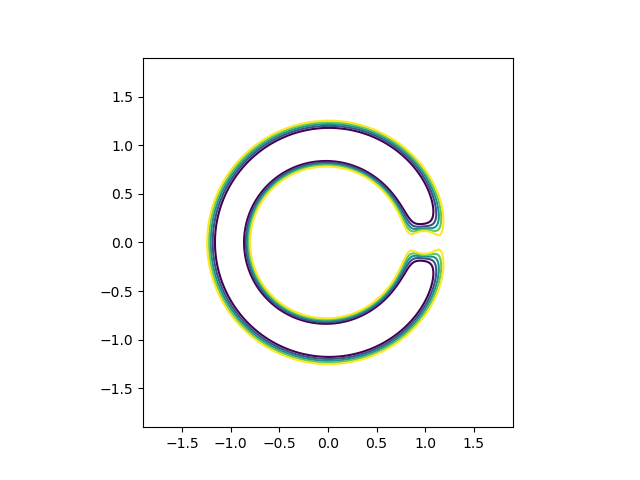

In [71]:
fig, ax = plt.subplots()
zv = ax.contour(
    x_grid,
    y_grid,
    2*U_grid,
    levels=[3.08, 3.1, 3.12, 3.14, 3.16],
    cmap="viridis",
)
ax.set_aspect("equal")

Which we cal also make interactive to add a modern twist ...

interactive(children=(FloatSlider(value=3.14, description='jacobi', layout=Layout(width='900px'), max=3.28, mi…

<function __main__.update_zero_velocity_plot(jacobi)>

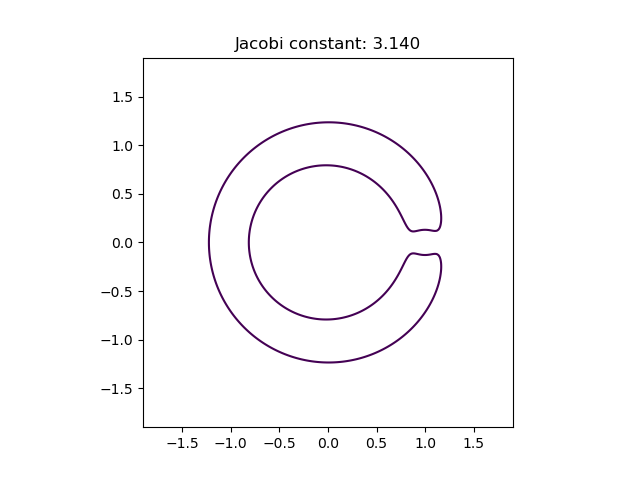

In [72]:
from ipywidgets import interact
from ipywidgets import FloatSlider, Layout


fig, ax = plt.subplots()

xx = np.linspace(-1.9, 1.9, 300)
yy = np.linspace(-1.9, 1.9, 300)
x_grid, y_grid = np.meshgrid(xx, yy)
z_grid = np.zeros(np.shape(x_grid))
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()
z_flat = z_grid.flatten()

def update_zero_velocity_plot(jacobi):
    ax.clear()  # <-- this line clears previous contours

    U_grid = effective_potential_U(
        np.vstack((x_flat, y_flat, z_flat)),
        pars=[[CR3BP_MU] * len(x_flat)],
    ).reshape(np.shape(x_grid))
    ax.contour(x_grid, y_grid, 2*U_grid, levels=[jacobi], cmap="viridis")
    ax.set_title(f"Jacobi constant: {jacobi:.3f}")
    fig.canvas.draw()  # force redraw in some environments
    ax.set_aspect("equal")

interact(
    update_zero_velocity_plot,
    jacobi=FloatSlider(
        value=1.57*2,
        min=1.49*2,
        max=1.64*2,
        step=0.002,
        readout_format=".3f",
        layout=Layout(width="900px"),
    ),
)

## Generating some orbits
Let us generate some orbits in the CR3BP starting from a circular LEO orbit. We do this "manually" shooting from the corresponding initial conditions and trying to find a trajectory actually intercepting the Moon. 

In [73]:
EARTH_MOON_DISTANCE = 384400000
# Let us set the initial conditions in the Earth-Moon system. An equatorial LEO at an altitude of ~1700 km
r = 8000000 / EARTH_MOON_DISTANCE
# In the reference frame of the CR3BP, the initial coordinate is thus:
x = -CR3BP_MU-r
# The initial velocity is obtained from the circular velocity at the distance r from the center of mass.
vy = -np.sqrt((1-CR3BP_MU)/r)+x

# We prform the numerical integration.
ta_cr3bp.time = 0.0
ta_cr3bp.state[:] = [x, 0, 0, 0.0, vy-2.705, 0.0]
ta_bcp.time = 0.0
ta_bcp.state[:] = ta_cr3bp.state
C = jacobi_C(ta_cr3bp.state, pars=[CR3BP_MU])
t_grid = np.linspace(0, 4*np.pi, 1000)
sol_cr3bp = ta_cr3bp.propagate_grid(t_grid)
sol_bcp = ta_bcp.propagate_grid(t_grid)

print("Value of the Jacobi constant C:", C)

Value of the Jacobi constant C: [2.26785855]


We plot the orbit in the CR3BP frame as well in the (more familiar) derotated frame ...

In [74]:
def plot(sol):
    fig, ax = plt.subplots()
    # In case we also plot the zero velocity curves, for many IC they will be completely opened and not show.
    zv = ax.contourf(
        x_grid,
        y_grid,
        2*U_grid,
        levels=[0.1,C[0]],
        colors='green'
    )
    ax.set_aspect("equal")
    # The x,y in the rotating frame
    xr = sol[-1][:, 0]
    yr = sol[-1][:, 1]
    # The x,y, in the derotated frame
    x =xr*np.cos(t_grid) - yr*np.sin(t_grid)
    y =xr*np.sin(t_grid) + yr*np.cos(t_grid)
    ax.plot(xr, yr, "k-", label="CR3BP trajectory")
    ax.plot(x,y, "r-", label="CR3BP trajectory")
    ax.plot(-CR3BP_MU,0, "bo", label="Earth")
    ax.plot(1-CR3BP_MU,0, "yo", label="Moon")
    return fig, ax

First without the Sun perturbation ....

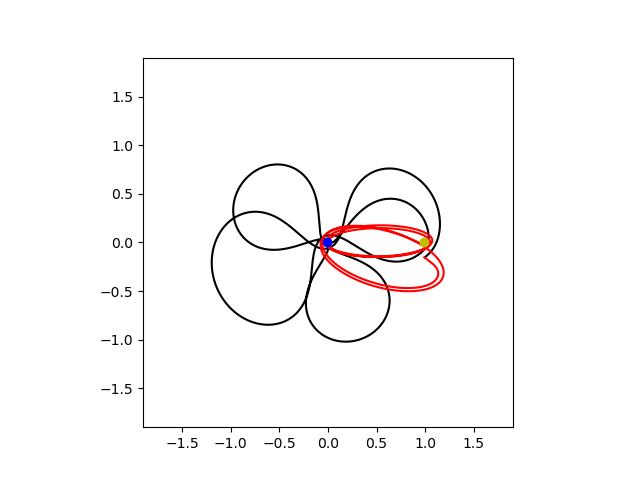

In [75]:
plot(sol_cr3bp);

... then with the Sun perturbation. We can see how a fly-by still happens but the overall geometry is significantly changed.

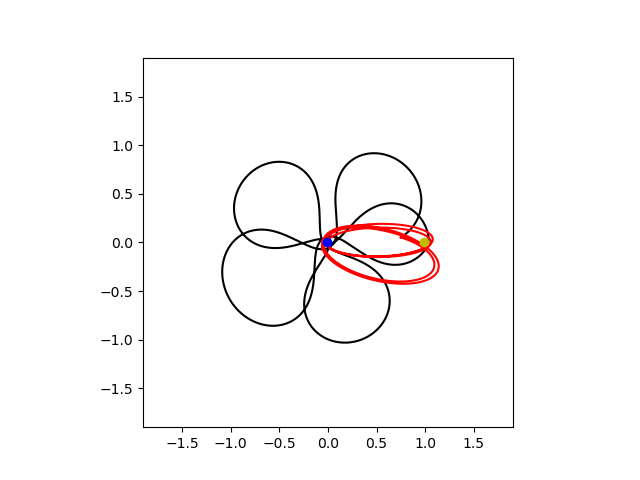

In [76]:
plot(sol_bcp);